In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('kaggle_data/train.csv')

In [4]:
#train_small = train.iloc[:10000]

In [161]:
#train_small = train.loc[np.random.choice(train.index, size=10000, replace=False)]

In [4]:
df = train

In [5]:
df = df[~df['MISSING_DATA']]#.drop(columns='MISSING_DATA')

In [202]:
# Over every single 
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df["LEN"] = df["POLYLINE"].apply(polyline_to_trip_duration)

In [203]:
from datetime import datetime
def parse_time(x):
    # We are using python's builtin datetime library
    # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

    # Each x is essentially a 1 row, 1 column pandas Series
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df[["YR", "MON", "DAY", "HR", "WK"]] = df[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [204]:
mapper = {'A': 1, 'B': 2, 'C': 3}

In [205]:
df['CALL_TYPE'] = df['CALL_TYPE'].replace(mapper)

In [206]:
metadata = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv')

In [207]:
metadata['coords'] = '[' + metadata['Longitude'].astype(str) + ', ' + metadata['Latitude'].astype(str) + ']'

In [208]:
# df['START_COORD'] = df['POLYLINE'].apply(lambda x: eval(x)).str[0]

In [209]:
metadata['Longitude'][40] = metadata['Latitude'][40][12:]
metadata['Latitude'][40] = metadata['Latitude'][40][0:12]

In [210]:
#df['ORIGIN_STAND'] = df['ORIGIN_STAND'].fillna(-1)

In [309]:
df.loc[df['CALL_TYPE'] == 1, 'ORIGIN_STAND'] = 0

In [310]:
df.loc[df['CALL_TYPE'] == 3, 'ORIGIN_STAND'] = -1

In [311]:
df['ORIGIN_STAND'] = df['ORIGIN_STAND'].fillna(-2)

In [312]:
#df.groupby('CALL_TYPE')['LEN'].mean().plot(kind='bar', ylabel='MEAN LEN')

In [362]:
coords = []

In [363]:
latLong_mean = metadata[['Latitude', 'Longitude']].astype(float).mean()
mean_coord = latLong_mean['Latitude'], latLong_mean['Longitude']

In [365]:
for coord in np.array(metadata[['Latitude', 'Longitude']]):
    coords.append((float(coord[0]), float(coord[1])))

In [366]:
df['ORIGIN_STAND_COORDS'] = df['ORIGIN_STAND'].apply(lambda origin_stand: coords[int(origin_stand)-1] if origin_stand > 0 else mean_coord if origin_stand == 0 else (np.nan, np.nan))

In [367]:
driver_route_list = list(df.sort_values(by=['TAXI_ID', 'TIMESTAMP']).reset_index(drop=True).groupby(['TAXI_ID', 'YR', 'MON', 'DAY'])['ORIGIN_STAND_COORDS'])

In [368]:
driver_routes_by_day = {t[0]: list(t[1]) for t in driver_route_list}

In [369]:
driver_routes_by_day

{(20000001, 2013, 7, 1): [(41.1632224305, -8.58404677278),
  (41.16037094272063, -8.622346637020796),
  (41.1603753216, -8.60936972153),
  (41.16037094272063, -8.622346637020796),
  (41.1507106526, -8.60690977259),
  (41.16037094272063, -8.622346637020796),
  (41.146299872, -8.61763808774),
  (41.16037094272063, -8.622346637020796),
  (41.16037094272063, -8.622346637020796),
  (41.1517836424, -8.62775942991),
  (41.1517836424, -8.62775942991),
  (41.1535929278, -8.60542646661),
  (41.1493101131, -8.60030852546),
  (41.16037094272063, -8.622346637020796)],
 (20000001, 2013, 7, 2): [(41.16037094272063, -8.622346637020796),
  (41.1535929278, -8.60542646661),
  (41.1535929278, -8.60542646661),
  (41.1535929278, -8.60542646661),
  (41.1535929278, -8.60542646661),
  (41.16037094272063, -8.622346637020796),
  (41.1610810603, -8.6575467588),
  (41.1754722349, -8.62779145139)],
 (20000001, 2013, 7, 3): [(41.16037094272063, -8.622346637020796),
  (41.16037094272063, -8.622346637020796),
  (41.15

In [226]:
metadata

,ID,Descricao,Latitude,Longitude,coords
0,1,Agra,41.1771457135,-8.60967,"[-8.6096702714, 41.1771457135]"
1,2,Alameda,41.15618964,-8.591064,"[-8.59106440506, 41.15618964]"
2,3,Aldoar,41.1705249231,-8.665876,"[-8.66587593213, 41.1705249231]"
3,4,Alfândega,41.1437639911,-8.621803,"[-8.62180322015, 41.1437639911]"
4,5,Amial,41.1835097223,-8.612726,"[-8.61272586967, 41.1835097223]"
...,...,...,...,...,...
58,59,Tenente Valadim,41.1607030178,-8.641205,"[-8.64120474891, 41.1607030178]"
59,60,Trindade,41.1511237005,-8.609843,"[-8.60984340203, 41.1511237005]"
60,61,Vinte e Quatro de Agosto,41.1493101131,-8.600309,"[-8.60030852546, 41.1493101131]"
61,62,Viso,41.1778737602,-8.646558,"[-8.64655750451, 41.1778737602]"


In [187]:
def find_closest_city(coords):
    #pass in START_COORDS
    if isinstance(coords, float):
        return None
    lat_dif = metadata['Latitude'].astype(float) - coords[1]
    long_dif = metadata['Longitude'].astype(float) - coords[0]
    distance = (lat_dif**2 + long_dif**2)**(1/2)
    return distance.idxmin() + 1

In [188]:
#df['CITY_ID'] = df['START_COORD'].apply(lambda x: find_closest_city(x))

In [189]:
from matplotlib.pyplot import figure

In [190]:
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (20,10)

# df.groupby('ORIGIN_STAND')['LEN'].mean().plot(kind='barh')

In [191]:
df['DATESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s')

In [192]:
df['DAY_OF_WEEK'] = df['DATESTAMP'].transform(lambda x: str.upper(x.day_name()))

<AxesSubplot:xlabel='DAY_OF_WEEK'>

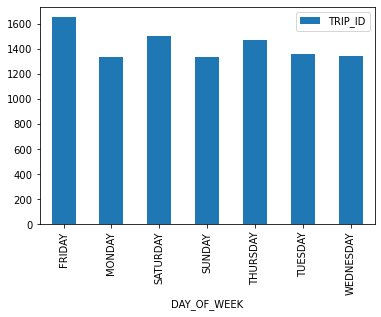

In [199]:
df.groupby('DAY_OF_WEEK')[['TRIP_ID']].count().plot(kind='bar') #(kind='scatter', ')
#plt.xticks = ['MONDAY', 'TUESDAY', 'WEDNESDAY','THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']

<AxesSubplot:xlabel='DAY_OF_WEEK'>

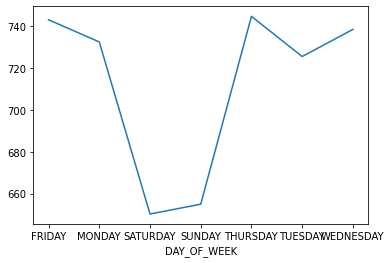

In [194]:
df.groupby('DAY_OF_WEEK')['LEN'].mean().plot()

In [85]:
for day in df['DAY_OF_WEEK'].unique():
    df[day] = (df['DAY_OF_WEEK'] == day).astype(int)

In [86]:
# building training dataset

In [87]:
train_df = df[['CALL_TYPE', 'ORIGIN_STAND', 'MON', 'DAY_OF_WEEK', 'HR']].copy()

In [88]:
for call_type in train_df['CALL_TYPE'].unique():
    train_df['CALL_TYPE' + ': ' + str(call_type)] = (train_df['CALL_TYPE'] == call_type).astype(int)
        
# excludes city 63 to prevent multicollinearity
for origin_id in list(range(-1, 63)):
    train_df['ORIGIN_STAND: ' + str(origin_id)] = (train_df['ORIGIN_STAND'] == origin_id).astype(int)

# exclude December to prevent multicollinearity
for mon in list(range(1,12)):
    train_df['MON: ' + str(mon)] = (train_df['MON'] == mon).astype(int)

# all 0 = sunday
for day in ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY']:
    train_df['DAY_OF_WEEK: ' + day] = (train_df['DAY_OF_WEEK'] == day).astype(int)

In [89]:
train_df = train_df.iloc[:, 4:].sort_index(axis=1)

In [90]:
train_df = train_df.reset_index(drop=True)

In [91]:
# append col of 1s, intercept
train_df = pd.concat([train_df, pd.Series(np.repeat(1, train_df.shape[0]))], axis=1)

In [92]:
X_train = np.array(train_df)

In [93]:
y_train = df['LEN']

In [94]:
y_train.shape

(10000,)

In [95]:
regularization_coefficients = [.00001, .0001, .001, .01, .1, 1, 10, 100]

In [96]:
def error(X, y, regs):
    errors = {}
    for coef in regs:
        w = np.linalg.inv(X.T @ X + coef * np.eye((X.T@X).shape[0])) @ X.T @ y
        train_MSE = (1/len(y)*(sum((w @ X.T - y)**2)))**(1/2)
        errors[coef] = train_MSE
    return errors

In [97]:
errors = error(X_train, y_train, regularization_coefficients)

In [98]:
errors
#pd.DataFrame(errors, regularization_coefficients).plot(kind='bar', xlabel='lambda', ylabel='H(x)')

{1e-05: 959.0557970283073,
 0.0001: 959.0557970286374,
 0.001: 959.0557970624217,
 0.01: 959.0558003874166,
 0.1: 959.0560860965815,
 1: 959.0664254271848,
 10: 959.1544745747402,
 100: 959.7877702589194}

In [99]:
regularizer = pd.Series(errors).idxmin()

In [100]:
w = np.linalg.inv(X_train.T @ X_train + regularizer * np.eye((X_train.T@X_train).shape[0])) @ X_train.T @ y_train

In [101]:
train_MSE = (1/len(y_train)*(sum((w @ X_train.T - y_train)**2)))**(1/2)
train_MSE

959.0557970283073

In [102]:
test = pd.read_csv('kaggle_data/test_public.csv')

In [103]:
test['CALL_TYPE'] = test['CALL_TYPE'].replace(mapper)

In [104]:
test.loc[test['CALL_TYPE'] == 1, 'ORIGIN_STAND'] = 0

In [105]:
test.loc[test['CALL_TYPE'] == 3, 'ORIGIN_STAND'] = -1

In [106]:
from datetime import datetime
def parse_time(x):
    # We are using python's builtin datetime library
    # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

    # Each x is essentially a 1 row, 1 column pandas Series
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [107]:
test['DATESTAMP'] = pd.to_datetime(test['TIMESTAMP'], unit='s')

In [108]:
test['DAY_OF_WEEK'] = test['DATESTAMP'].transform(lambda x: str.upper(x.day_name()))

In [109]:
test_df = test[['CALL_TYPE', 'ORIGIN_STAND', 'MON', 'DAY_OF_WEEK', 'HR']].copy()

In [110]:
for call_type in test_df['CALL_TYPE'].unique():
    test_df['CALL_TYPE' + ': ' + str(call_type)] = (test_df['CALL_TYPE'] == call_type).astype(int)
        
# excludes city 63 to prevent multicollinearity
for origin_id in list(range(-1, 63)):
    test_df['ORIGIN_STAND: ' + str(origin_id)] = (test_df['ORIGIN_STAND'] == origin_id).astype(int)

# exclude December to prevent multicollinearity
for mon in list(range(1,12)):
    test_df['MON: ' + str(mon)] = (test_df['MON'] == mon).astype(int)

# all 0 = sunday
for day in ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY']:
    test_df['DAY_OF_WEEK: ' + day] = (test_df['DAY_OF_WEEK'] == day).astype(int)  

In [111]:
X_test = test_df.iloc[:, 4:].sort_index(axis=1)

In [112]:
# append col of 1s, intercept
X_test = pd.concat([X_test, pd.Series(np.repeat(1, X_test.shape[0]))], axis=1)

In [113]:
X_test = np.array(X_test)

In [114]:
submission = pd.DataFrame(np.dot(X_test, w))

In [115]:
submission.columns = ['TRAVEL_TIME']

In [116]:
submission.index = test['TRIP_ID']

In [117]:
submission

,TRAVEL_TIME
TRIP_ID,
T1,887.759809
T2,754.458059
T3,887.759809
T4,713.851728
T5,772.061546
...,...
T323,678.692040
T324,579.552412
T325,712.128807


In [118]:
submission.to_csv('submission.csv')
